# **LOAN DEFAULT PREDICTION - HOME CREDIT**

Data Source:
The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx), a service that offers credit (loans) to people who don't have access to banking services.

Data Description:
The diagram below illustrates the relationships between all datasets used in this project:

![image](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

For this analysis, we focus solely on the main application datasets (application_train and application_test) including customers informations.

Goals: Predict loan repayment ability to approve the right customers and set them up for success.


# Settings

In [ ]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/PBI/HomeCredit_DS/Dataset')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/PBI/HomeCredit_DS/Dataset'

# Data Collecting

Training Data has 307511 rows of loan records and 122 columns of features including Target (Label).

Training Data has 48744 rows of loan records and 121 columns of features, not including Target (Label).

In [ ]:
# Training Data
app_train = pd.read_csv('application_train.csv')
print("shape:", app_train.shape)
app_train.head()

shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Number of columns for each type
app_train.dtypes.value_counts()

,count
float64,65
int64,41
object,16


In [ ]:
# Testing Data
app_test = pd.read_csv('application_test.csv')
print("shape:", app_test.shape)
app_test.head()

shape: (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Number of columns for each type
app_test.dtypes.value_counts()

,count
float64,65
int64,40
object,16


# Data Preprocessing

## Examine Missing Values

In [ ]:
# Make Function to identify how much columns have missing values
def missing_values_table(df):
        # Total missing values
        miss_val = df.isnull().sum()

        # Percentage of missing values
        miss_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        miss_val_table = pd.concat([miss_val, miss_val_percent], axis=1)

        # Rename the columns
        miss_val_table_ren_columns = miss_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        miss_val_table_ren_columns = miss_val_table_ren_columns[
            miss_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(miss_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return miss_val_table_ren_columns

In [ ]:
# Missing Values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_MODE,214865,69.9
COMMONAREA_AVG,214865,69.9
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_AVG,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_MODE,210199,68.4


## Encoding Categorical Features

To carry these categorical features, there are two main ways:
1. Label Encoding : Set each unique category in categorical features with integers (the numbers have no real meaning). Good for binary classification. No new columns are created. it work properly with categorical features that have 2 unique classes. Because the more unique classes we have, the model might think the number have meaning, like weighing each unique classes.

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/label_encoding.png)

* One-hot encoding: Create a new column for each unique category in the categorical features. Assign a value of 1 to the column corresponding to the category and a value of 0 to all other new columns. it work safely with categorical features that have more than 2 unique classes, because it create separate categories.

![image](https://raw.githubusercontent.com/WillKoehrsen/Machine-Learning-Projects/master/one_hot_encoding.png)


In [ ]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

,0
NAME_CONTRACT_TYPE,2
CODE_GENDER,3
FLAG_OWN_CAR,2
FLAG_OWN_REALTY,2
NAME_TYPE_SUITE,7
NAME_INCOME_TYPE,8
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,6
NAME_HOUSING_TYPE,6
OCCUPATION_TYPE,18


In [ ]:
# Label Encoding
label_encoder = LabelEncoder()

# Counter to track how many columns we encoded
binary_label_count = 0

# Loop through all columns in the training set
for col in app_train.columns:
    # Check if the column is categorical (object type)
    if app_train[col].dtype == 'object':
        # Check if it has only 2 unique values
        if app_train[col].nunique() <= 2:
            # Fit on training data
            label_encoder.fit(app_train[col])
            # Transform both train and test
            app_train[col] = label_encoder.transform(app_train[col])
            app_test[col] = label_encoder.transform(app_test[col])
            binary_label_count += 1

print(f"{binary_label_count} binary categorical columns were label encoded.")

4 binary categorical columns were label encoded.


In [ ]:
# One-hot Encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print("Training Features shape:", app_train.shape)
print("Testing Features shape:", app_test.shape)

Training Features shape: (307511, 242)
Testing Features shape: (48744, 238)


## Aligning Training and Testing Data

In [ ]:
# Saves the target variable (TARGET) before alignment
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 239)
Testing Features shape:  (48744, 238)


## Exploratory Data Analysis

Exploratory Data Analysis (EDA) is the process of exploring a dataset to understand what it can tell us. We do this by calculating simple statistics and creating charts to spot trends, patterns, unusual values, or relationships in the data. Usually, we start with a big-picture view, then zoom in on specific details that look interesting. What we find can be useful on its own or help us make better decisions when building models, like choosing which features to use.

#### Check the main column (Target) distribution

In [ ]:
app_train['TARGET'].value_counts()

,count
TARGET,
0,282686
1,24825


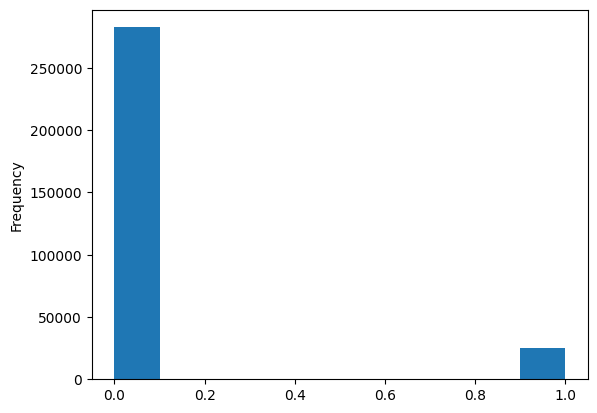

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

We can see that there is a class imbalance problem, where the target value 0 (loans that are repaid) is much greater than 1 (loans that are defaulted).

Therefore, the performance of the model to be created will be measured using ROC AUC. This metric was chosen because it evaluates how well the model separates two classes: customers who repay their loans versus those who default. Unlike simple accuracy, ROC AUC is not affected by class imbalance and provides a fair measure of how reliably the model distinguishes between good and risky borrowers.

#### Check the features column to find any anomalies

In [ ]:
# Show all columns
pd.set_option('display.max_columns', None)
app_train.describe()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,307511.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,307511.000000
mean,278180.518577,0.095213,0.340108,0.693673,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.1142

In [ ]:
pd.reset_option('display.max_columns')

Based on the features (columns except Target Column) we have, in general we can identify anomalies value through their statistical information (mean, min, med, max, std) using the describe method. The anomalies are like miss-typed values, extreme values, unrelated values, etc . Some Examples:
- DAYS_BIRTH : all the values are negative because recorded relative to the current loan application. (not anomaly)
- DAYS_EMPLOYED : the max value looks weird, because it's positive and if we converted to Years (/365) it is around 1000 years. (anomaly)

First, we need to handle this value, one of the safest approach is set the anomalies into missing values (with not a number (np.nan)), then have them filled in (using Imputation) before train the model.

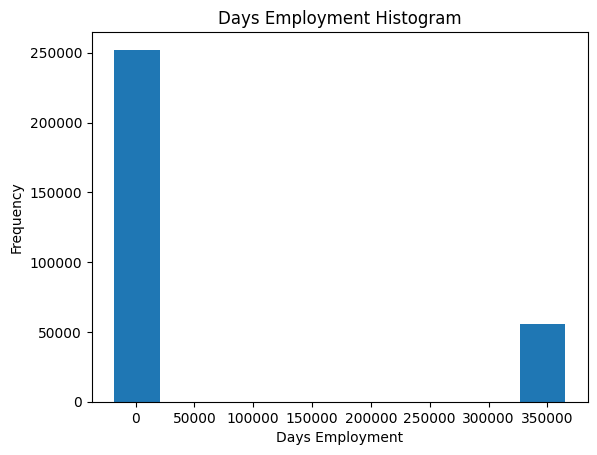

In [ ]:
# Days Employed have anomalies (not just being positive, also count as 1000 years)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

In [ ]:
# NaN values for DAYS_EMPLOYED: 365.243 -> nan
app_train['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)

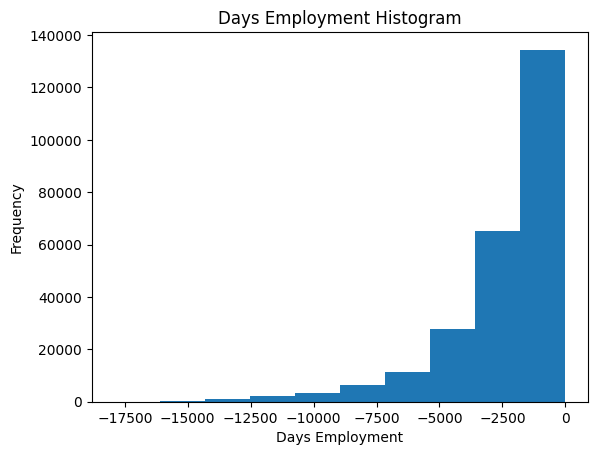

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment');

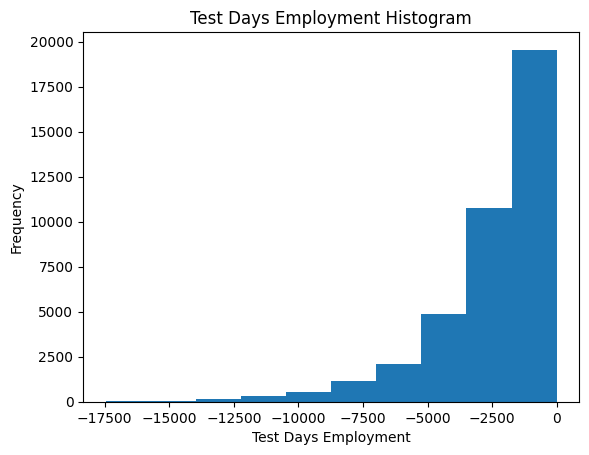

In [ ]:
# Apply to testing data
app_test['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
app_test['DAYS_EMPLOYED'].plot.hist(title = 'Test Days Employment Histogram');
plt.xlabel('Test Days Employment');

#### Correlation

This is one of way we must do before making the model, correlation is needed to understand the relationship between every features to the Target, also to help doing features selection for the best performance of the model.

In [ ]:
# Using Default method (Pearson Correlation), better because all the features already numeric
correlations = app_train.corr()['TARGET'].sort_values()
print(correlations.head(10))   # most negative
print(correlations.tail(10))   # most positive

EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
FLOORSMAX_MODE                         -0.043226
Name: TARGET, dtype: float64
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
CODE_GENDER_M                  0.054713
DAYS_LAST_PHONE_CHANGE         0.055218
NAME_INCOME_TYPE_Working       0.057481
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.074958
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


Explanation :
- Values close to +1 or -1 mean a strong linear relationship.
- Values close to 0 mean weak or no linear relationship.
- Negative correlation → higher values = less chance of default (safer borrower)
- Positive correlation → higher values = more chance of default

#### `Some Insights from the features that have strong relationship`

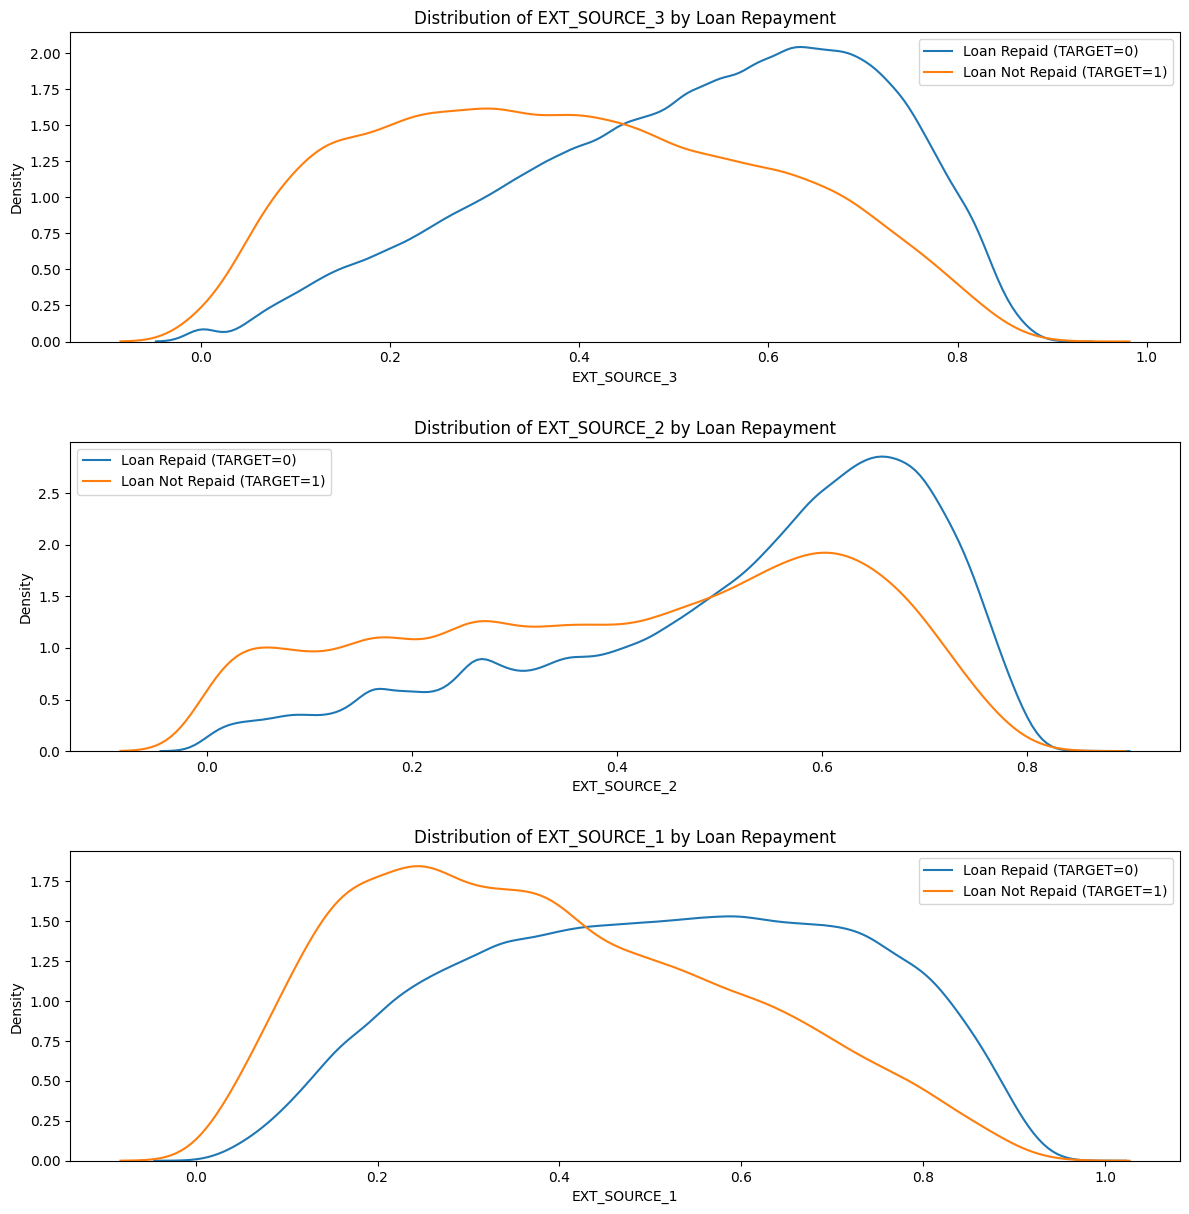

In [ ]:
### EXT_SOURCE 3,2,1 ### (Negative correlation from EXT_SOURCE indicates that the higher the EXT_SOURCE value, the greater the likelihood that the client will repay the loan.)
plt.figure(figsize = (12, 20))

# iterate through the new features
for i, feature in enumerate(['EXT_SOURCE_3',
                             'EXT_SOURCE_2',
                             'EXT_SOURCE_1']):

    # create a new subplot for each feature
    plt.subplot(5, 1, i + 1)

    # plot repaid loans (TARGET = 0)
    sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 0, feature], label = 'Loan Repaid (TARGET=0)')

    # plot not repaid loans (TARGET = 1)
    sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 1, feature], label = 'Loan Not Repaid (TARGET=1)')

    # Label the plots
    plt.title(f'Distribution of {feature} by Loan Repayment')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout(h_pad = 2.5)
plt.show()

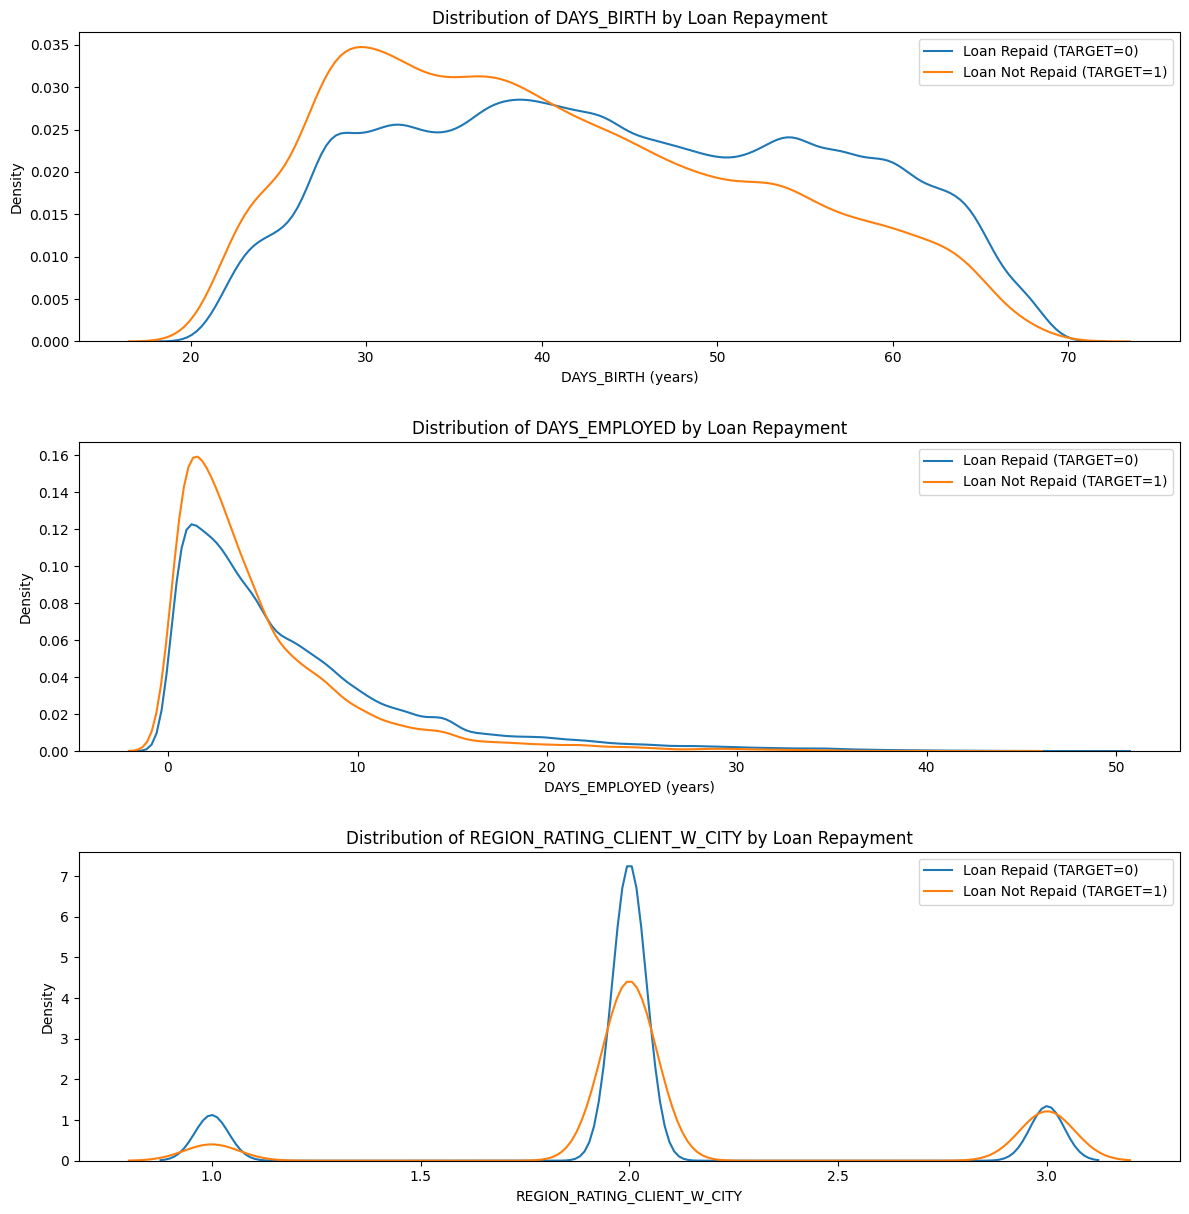

In [ ]:
# The three features with the strongest positive correlation are REGION_RATING_CLIENT_W_CITY, DAYS_EMPLOYED, & DAYS_BIRTH. this correlation indicates that the higher the feature value,the greater chance of default)

plt.figure(figsize=(12, 20))

# iterate through the selected features
for i, feature in enumerate(['DAYS_BIRTH',
                             'DAYS_EMPLOYED',
                             'REGION_RATING_CLIENT_W_CITY']):

    plt.subplot(5, 1, i + 1)

    # If feature is in days → convert to years
    if 'DAYS' in feature:
        sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 0, feature] / -365,
                    label='Loan Repaid (TARGET=0)')
        sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 1, feature] / -365,
                    label='Loan Not Repaid (TARGET=1)')
        plt.xlabel(f"{feature} (years)")

    else:
        sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 0, feature],
                    label='Loan Repaid (TARGET=0)')
        sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 1, feature],
                    label='Loan Not Repaid (TARGET=1)')
        plt.xlabel(feature)

    plt.title(f'Distribution of {feature} by Loan Repayment')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout(h_pad=2.5)
plt.show()


## Feature Engineering

One of the process that make the machine learning models work better is Feature Engineering (Good Features = Smarter Models). `Feature Engineering` refers to the process of selecting, transforming, or creating features (inputs/columns) from raw data to improve the performance of a machine learning model.

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist. So here [some recommendations](https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features) :

* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age

In [ ]:
app_train_new = app_train.copy()
app_test_new = app_test.copy()

In [ ]:
# Training Data New features (percentages)
app_train_new['DAYS_EMPLOYED_PERC'] = app_train_new['DAYS_EMPLOYED'] / app_train_new['DAYS_BIRTH']
app_train_new['INCOME_CREDIT_PERC'] = app_train_new['AMT_INCOME_TOTAL'] / app_train_new['AMT_CREDIT']
app_train_new['INCOME_PER_PERSON'] = app_train_new['AMT_INCOME_TOTAL'] / app_train_new['CNT_FAM_MEMBERS']
app_train_new['ANNUITY_INCOME_PERC'] = app_train_new['AMT_ANNUITY'] / app_train_new['AMT_INCOME_TOTAL']
app_train_new['PAYMENT_RATE'] = app_train_new['AMT_ANNUITY'] / app_train_new['AMT_CREDIT']

In [ ]:
# Testing Data New features (percentages)
app_test_new['DAYS_EMPLOYED_PERC'] = app_test_new['DAYS_EMPLOYED'] / app_test_new['DAYS_BIRTH']
app_test_new['INCOME_CREDIT_PERC'] = app_test_new['AMT_INCOME_TOTAL'] / app_test_new['AMT_CREDIT']
app_test_new['INCOME_PER_PERSON'] = app_test_new['AMT_INCOME_TOTAL'] / app_test_new['CNT_FAM_MEMBERS']
app_test_new['ANNUITY_INCOME_PERC'] = app_test_new['AMT_ANNUITY'] / app_test_new['AMT_INCOME_TOTAL']
app_test_new['PAYMENT_RATE'] = app_test_new['AMT_ANNUITY'] / app_test_new['AMT_CREDIT']

In [ ]:
print("Train shape:", app_train_new.shape)
print("Test shape:", app_test_new.shape)

Train shape: (307511, 244)
Test shape: (48744, 243)


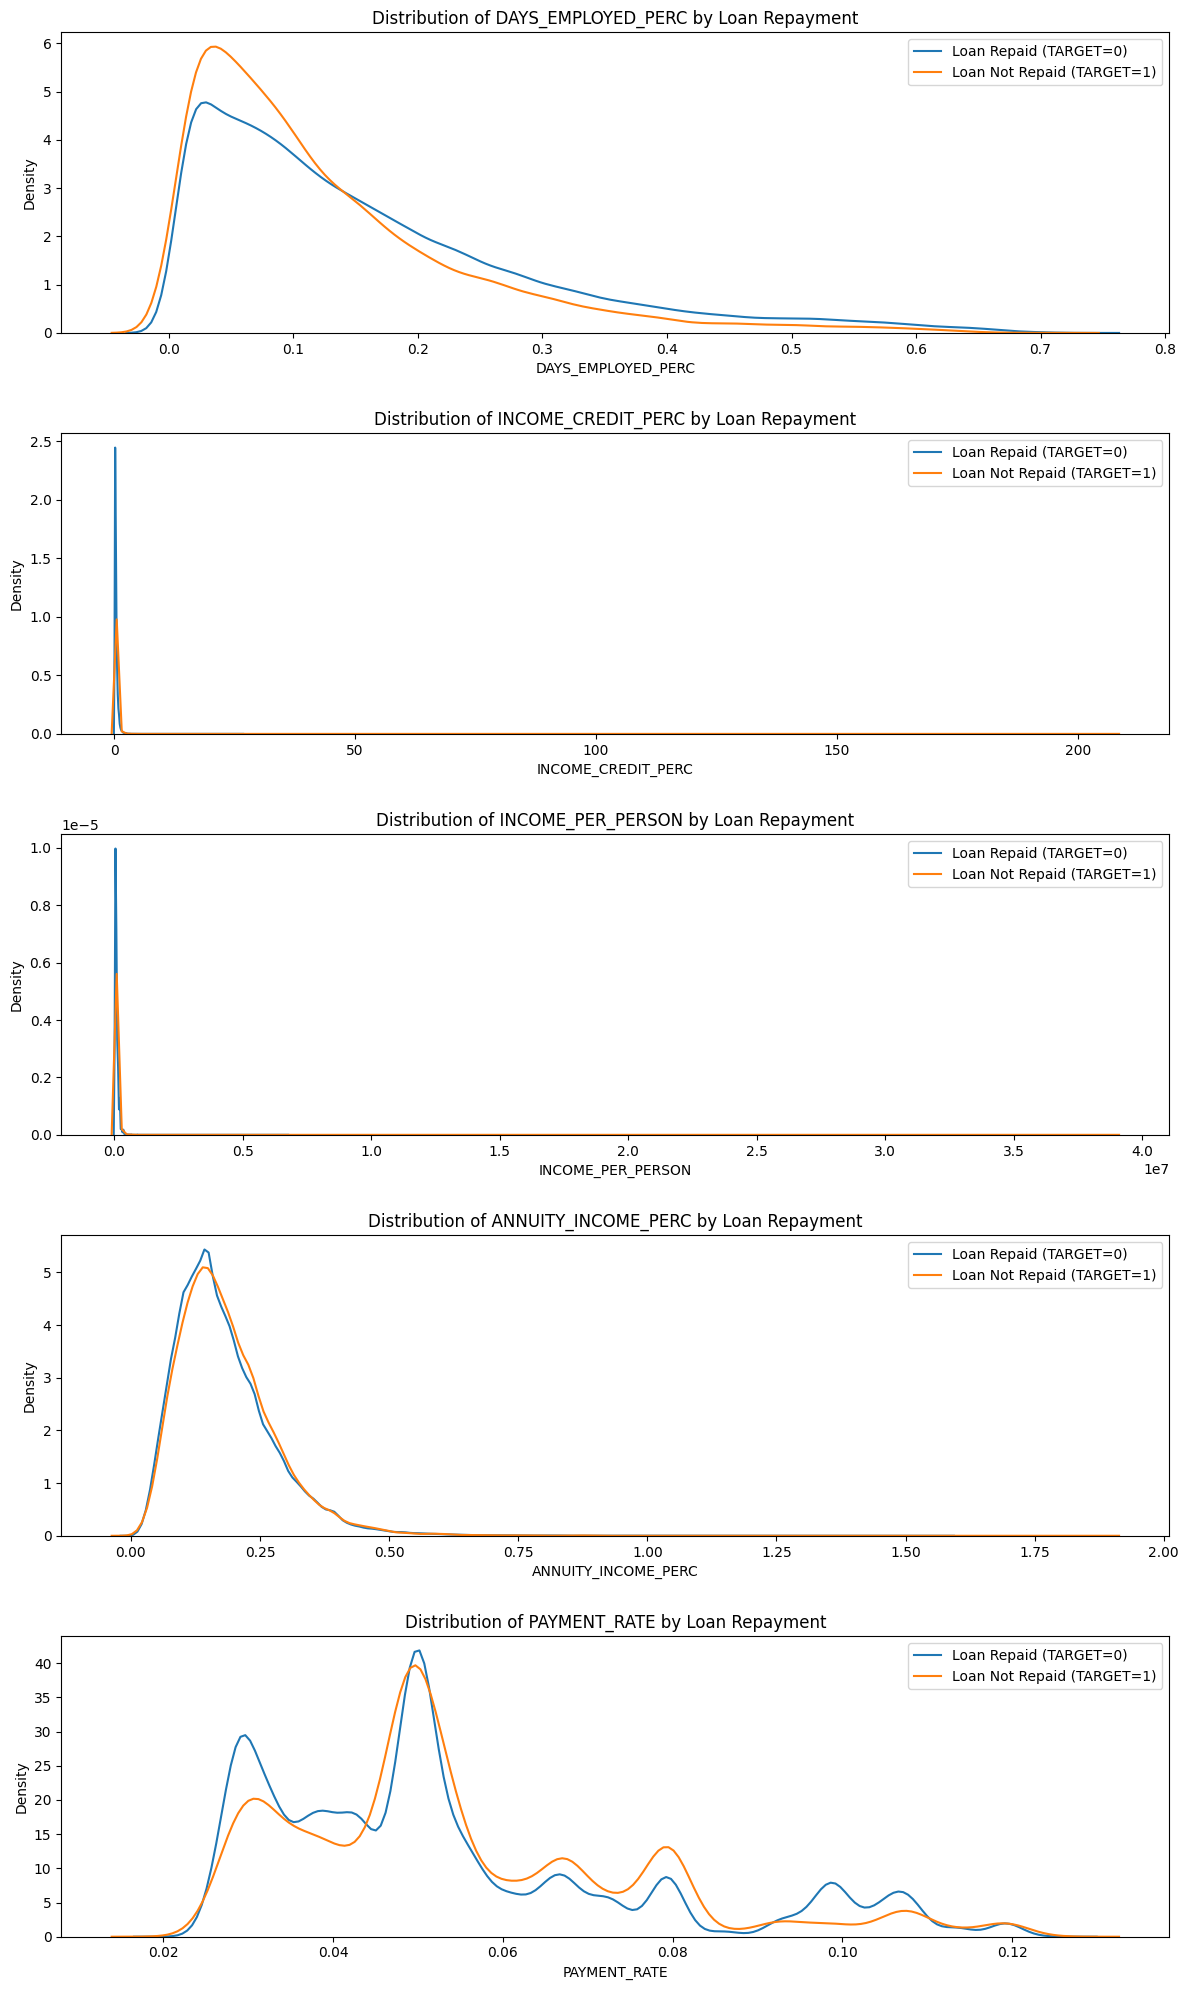

In [ ]:
plt.figure(figsize = (12, 20))

# iterate through the new features
for i, feature in enumerate(['DAYS_EMPLOYED_PERC',
                             'INCOME_CREDIT_PERC',
                             'INCOME_PER_PERSON',
                             'ANNUITY_INCOME_PERC',
                             'PAYMENT_RATE']):

    # create a new subplot for each feature
    plt.subplot(5, 1, i + 1)

    # plot repaid loans (TARGET = 0)
    sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 0, feature], label = 'Loan Repaid (TARGET=0)')

    # plot not repaid loans (TARGET = 1)
    sns.kdeplot(app_train_new.loc[app_train_new['TARGET'] == 1, feature], label = 'Loan Not Repaid (TARGET=1)')

    # Label the plots
    plt.title(f'Distribution of {feature} by Loan Repayment')
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout(h_pad = 2.5)
plt.show()

# MODEL

## Logistic regression (Baseline)

For the baseline model, I used Logistic Regression to predict the probability of loan default. Logistic Regression is a simple yet effective model for classification tasks and provides a good starting point before moving to more complex models.

In [ ]:
# Features (X) and target (y)
X = app_train.drop(columns=['TARGET'])
y = app_train['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Median imputation (Handling missing values)
imputer = SimpleImputer(strategy='median')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print('Training shape:', x_train.shape)
print('Validation shape:', x_test.shape)

### Logistic Regression Model (Training)
log_reg = LogisticRegression(class_weight="balanced", C = 0.0001)
log_reg.fit(x_train, y_train)

Training shape: (246008, 238)
Validation shape: (61503, 238)


LogisticRegression(C=0.0001, class_weight='balanced')

In [ ]:
# Predict probabilities
log_reg_test_pred = log_reg.predict_proba(x_test)[:, 1]

# ROC AUC
test_auc = roc_auc_score(y_test, log_reg_test_pred)
print("Logistic Regression ROC AUC (Test):", test_auc)

Logistic Regression ROC AUC (Test): 0.7158422637214258


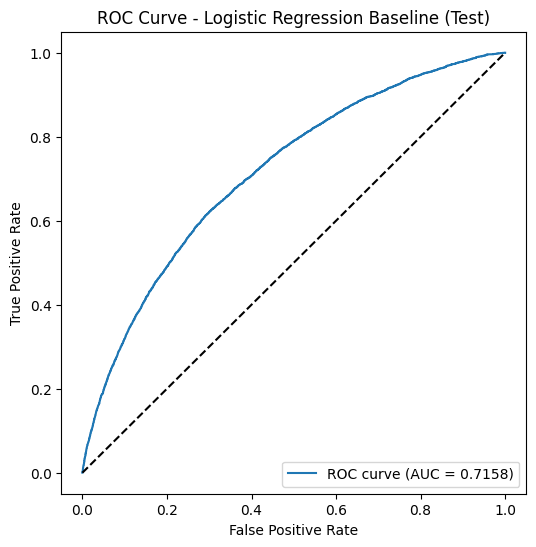

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, log_reg_test_pred)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.4f})'.format(test_auc))
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression Baseline (Test)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Additional

# Take only the SK_ID_CURR column from the test set
# submit = app_test[['SK_ID_CURR']].copy()

# Add predictions
# submit['TARGET'] = log_reg_test_pred

# Save
# submit.to_csv("log_reg_baseline.csv", index=False)

## Random Forest

In [ ]:
### RF MODEL ###
# Features (X) and target (y)
X = app_train.drop(columns=['TARGET'])
y = app_train['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Median imputation
imputer = SimpleImputer(strategy='median')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [ ]:
# Predict probabilities
rf_test_pred = rf_model.predict_proba(x_test)[:, 1]

# ROC AUC
test_auc = roc_auc_score(y_test, rf_test_pred)
print("Random Forest ROC AUC (Test):", test_auc)

Random Forest ROC AUC (Test): 0.731138794756629


In [ ]:
# Get feature importances
importances = rf_model.feature_importances_

# Match with column names
feature_importances = pd.DataFrame({
    'feature': X.columns,    # original feature names
    'importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Show top 15
print(feature_importances.head(15))

                                  feature  importance
33                           EXT_SOURCE_3    0.161576
32                           EXT_SOURCE_2    0.155344
31                           EXT_SOURCE_1    0.058420
11                          DAYS_EMPLOYED    0.048166
10                             DAYS_BIRTH    0.035179
8                         AMT_GOODS_PRICE    0.028905
82                 DAYS_LAST_PHONE_CHANGE    0.024912
6                              AMT_CREDIT    0.019923
13                        DAYS_ID_PUBLISH    0.019677
126  NAME_EDUCATION_TYPE_Higher education    0.018292
7                             AMT_ANNUITY    0.014854
110                         CODE_GENDER_M    0.013320
109                         CODE_GENDER_F    0.012515
12                      DAYS_REGISTRATION    0.012511
14                            OWN_CAR_AGE    0.010444


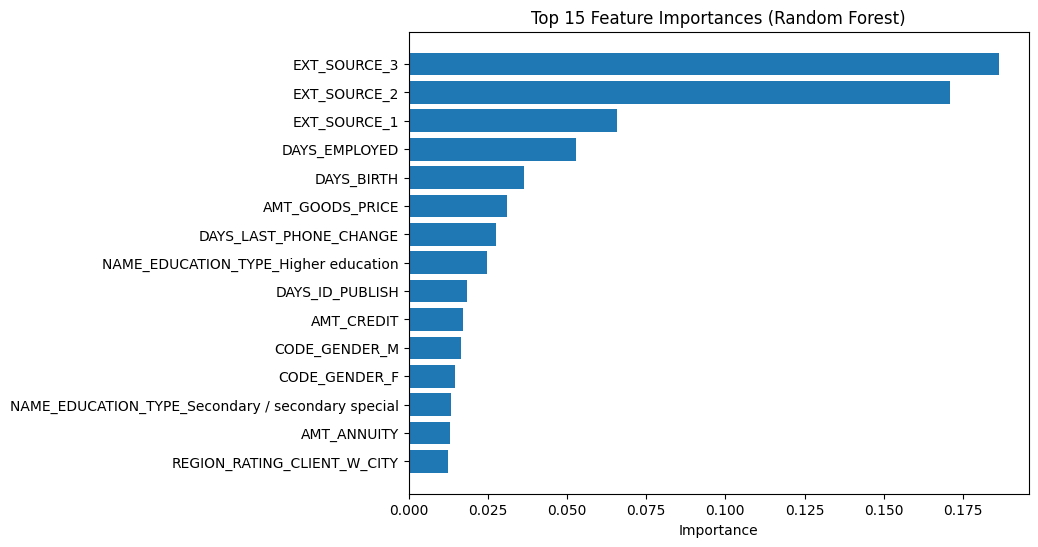

In [ ]:
# Plot top 15 features
plt.figure(figsize=(8,6))
plt.barh(feature_importances['feature'].head(15),
         feature_importances['importance'].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

In [ ]:
### RF MODEL IMPROVED ###
# Features (X) and target (y)
X = app_train.drop(columns=['TARGET'])
y = app_train['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Median imputation
imputer = SimpleImputer(strategy='median')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

# Define parameter grid
param_dist = {
    'n_estimators': [200, 500],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'class_weight': ['balanced']
}

### Random Forest Model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Randomized search
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=5,            # number of random combinations to try
    scoring='roc_auc',    # optimize for ROC AUC
    cv=3,                 # 3-fold cross validation
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best ROC AUC Score:", random_search.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None, 'class_weight': 'balanced'}
Best ROC AUC Score: 0.7324498649318789


In [ ]:
# Train RF with best parameters
best_rf = random_search.best_estimator_

# Prediction Probabilities
rf_test_pred = best_rf.predict_proba(x_test)[:, 1]

# ROC AUC
test_auc = roc_auc_score(y_test, rf_test_pred)
print("Random Forest ROC AUC (Test):", test_auc)

Random Forest ROC AUC (Test): 0.7370469234256752


In [ ]:
# Get feature importances
importances = best_rf.feature_importances_

# Match with column names
feature_importances = pd.DataFrame({
    'feature': X.columns,    # original feature names
    'importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Show top 15
print(feature_importances.head(15))

                       feature  importance
33                EXT_SOURCE_3    0.070950
32                EXT_SOURCE_2    0.067474
11               DAYS_EMPLOYED    0.034202
10                  DAYS_BIRTH    0.034032
13             DAYS_ID_PUBLISH    0.030874
31                EXT_SOURCE_1    0.030510
7                  AMT_ANNUITY    0.030083
82      DAYS_LAST_PHONE_CHANGE    0.029686
12           DAYS_REGISTRATION    0.029163
6                   AMT_CREDIT    0.028755
0                   SK_ID_CURR    0.028005
8              AMT_GOODS_PRICE    0.027069
9   REGION_POPULATION_RELATIVE    0.022909
5             AMT_INCOME_TOTAL    0.021344
24     HOUR_APPR_PROCESS_START    0.018210


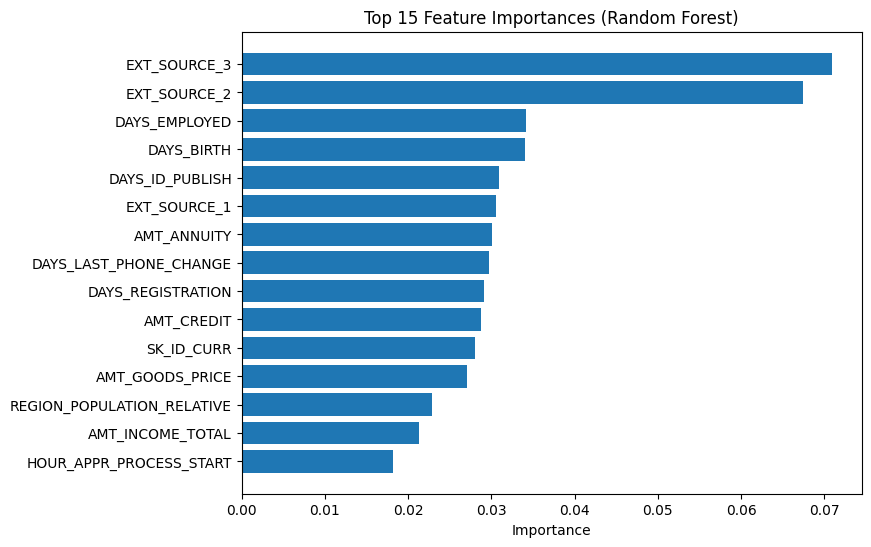

In [ ]:
# Plot top 15 features
plt.figure(figsize=(8,6))
plt.barh(feature_importances['feature'].head(15),
         feature_importances['importance'].head(15))
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.show()

## LIGHTGBM

In [ ]:
# Features (X) and target (y)
X = app_train.drop(columns=['TARGET']).copy()
y = app_train['TARGET']

# Replace spaces and special characters with underscores
X.columns = X.columns.str.replace('[^A-Za-z0-9_]+', '_', regex=True)

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM Model
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(x_train, y_train)

[LightGBM] [Info] Number of positive: 19876, number of negative: 226132
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.165872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11790
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 230
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080794 -> initscore=-2.431606
[LightGBM] [Info] Start training from score -2.431606


LGBMClassifier(learning_rate=0.05, n_estimators=500, n_jobs=-1, random_state=42)

In [ ]:
# Prediction Probability
lgb_test_pred = lgb_model.predict_proba(x_test)[:, 1]

# ROC AUC
test_auc = roc_auc_score(y_test, lgb_test_pred)
print("LightGBM ROC AUC (Test):", test_auc)

LightGBM ROC AUC (Test): 0.7599026497047834


## Models With New Features

In [ ]:
# LR MODEL #
# Features (X) and target (y)
X = app_train_new.drop(columns=['TARGET'])
y = app_train_new['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Median imputation
imputer = SimpleImputer(strategy='median')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print('Training shape:', x_train.shape)
print('Validation shape:', x_test.shape)

### Logistic Regression Model
log_reg = LogisticRegression(class_weight ="balanced", C = 0.0001)
log_reg.fit(x_train, y_train)

Training shape: (246008, 243)
Validation shape: (61503, 243)


LogisticRegression(C=0.0001, class_weight='balanced')

In [ ]:
# Predict probabilities
log_reg_test_pred = log_reg.predict_proba(x_test)[:, 1]

# ROC AUC
test_auc = roc_auc_score(y_test, log_reg_test_pred)
print("Logistic Regression ROC AUC (Test):", test_auc)

Logistic Regression ROC AUC (Test): 0.7170130664674863


In [ ]:
# RF MODEL #
# Features (X) and target (y)
X = app_train_new.drop(columns=['TARGET'])
y = app_train_new['TARGET']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Median imputation
imputer = SimpleImputer(strategy='median')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1,
    min_samples_split=10,
    min_samples_leaf= 1
)
rf_model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

In [ ]:
# Predict probabilities
rf_test_pred = rf_model.predict_proba(x_test)[:, 1]

# ROC AUC
test_auc = roc_auc_score(y_test, rf_test_pred)
print("Random Forest ROC AUC (Test):", test_auc)

Random Forest ROC AUC (Test): 0.7389789903770233
